Task:
Analyzing the content of the E-Commerce database that contains the purchases made by approximate ~4000 customers over a period of one year
To develop a model that allows to anticipate or predict the purchases that will be made by a new customer during the following & this year, based on the data available from the previous purchases.


In [2]:
# Importing all the required libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import plotly
plotly.offline.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual,VBox,HBox,Layout
import ipywidgets as widgets




In [3]:
import pandas as pd

# making data frame from csv file
data = pd.read_csv(r"C:\Users\santh\Downloads\Datasets\E-commerce.csv",encoding="ISO-8859-1")

# generating one row
df = data.sample(frac =.10)


In [4]:
df.count()

InvoiceNo      54191
StockCode      54191
Description    54057
Quantity       54191
InvoiceDate    54191
UnitPrice      54191
CustomerID     40682
Country        54191
dtype: int64

In [5]:
df.describe()

Quantity     UnitPrice    CustomerID
count  54191.000000  54191.000000  40682.000000
mean       9.521747      4.572726  15291.764318
std       37.635511     85.003215   1715.717299
min    -2376.000000      0.000000  12347.000000
25%        1.000000      1.250000  13956.000000
50%        3.000000      2.100000  15159.000000
75%       10.000000      4.130000  16800.000000
max     2400.000000  16888.020000  18287.000000

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54191 entries, 263022 to 262348
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    54191 non-null  object 
 1   StockCode    54191 non-null  object 
 2   Description  54057 non-null  object 
 3   Quantity     54191 non-null  int64  
 4   InvoiceDate  54191 non-null  object 
 5   UnitPrice    54191 non-null  float64
 6   CustomerID   40682 non-null  float64
 7   Country      54191 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 3.7+ MB


In [7]:
df.isnull().sum()

InvoiceNo          0
StockCode          0
Description      134
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     13509
Country            0
dtype: int64

In [8]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df.Quantity*df.UnitPrice
df['Year']=df.InvoiceDate.dt.year
df['Month']=df.InvoiceDate.dt.month
df['Week']=df.InvoiceDate.dt.isocalendar().week
df['Year_Month']=df.InvoiceDate.dt.to_period('M')
df['Hour']=df.InvoiceDate.dt.hour
df['Day']=df.InvoiceDate.dt.day
df['is_cancelled']=df.InvoiceNo.apply(lambda x: 'Yes' if x[0]=='C' else 'No')
df['weekday'] = df.InvoiceDate.dt.day_name()
df['Quarter'] = df.Month.apply(lambda m:'Q'+str(ceil(m/4)))
df['Date']=pd.to_datetime(df[['Year','Month','Day']])
df.head()

InvoiceNo StockCode                          Description  Quantity  \
263022    559930     21212      PACK OF 72 RETROSPOT CAKE CASES        24   
345849    567180    47590B          PINK HAPPY BIRTHDAY BUNTING         4   
479645    577174     22063  CERAMIC BOWL WITH STRAWBERRY DESIGN         1   
65319     541695     22983                  CARD BILLBOARD FONT         1   
245686    558626     22398           MAGNETS PACK OF 4 SWALLOWS        12   

               InvoiceDate  UnitPrice  CustomerID         Country  Sales  \
263022 2011-07-14 09:22:00       0.55     17738.0  United Kingdom  13.20   
345849 2011-09-18 14:56:00       5.45     17802.0  United Kingdom  21.80   
479645 2011-11-18 10:58:00       2.95     17841.0  United Kingdom   2.95   
65319  2011-01-20 18:01:00       0.83         NaN  United Kingdom   0.83   
245686 2011-06-30 17:34:00       1.25     12569.0         Germany  15.00   

        Year  Month  Week Year_Month  Hour  Day is_cancelled   weekday  \
263022  2011      7    28    2011-07     9   14           No  Thursday   
345849  2011      9    37    2011-09    14   18           No    Sunday   
479645  2011     11    46    2011-11    10   18           No    Friday   
65319   2011      1     3    2011-01    18   20           No  Thursday   
245686  2011      6    26    2011-06    17   30           No  Thursday   

       Quarter       Date  
263022      Q2 2011-07-14  
345849      Q3 2011-09-18  
479645      Q3 2011-11-18  
65319       Q1 2011-01-20  
245686      Q2 2011-06-30

CustomerID and Description is missing.Since it represents 25% of the data This would affect in finding Potential customers

<BarContainer object of 2 artists>

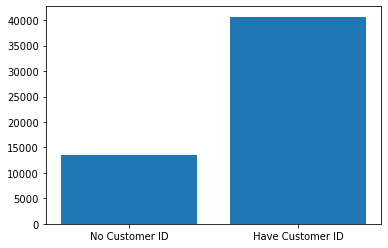

In [9]:
import matplotlib.pyplot as plt

no_customer_id = len(df[df['CustomerID'].isnull()].index)
have_customer_id = len(df[~df['CustomerID'].isnull()].index)

plt.bar(['No Customer ID','Have Customer ID'],[no_customer_id, have_customer_id])


In [10]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=df.UnitPrice),row=1, col=1)
fig.add_trace(go.Box(y=df.Quantity),row=1, col=2)
fig.add_trace(go.Box(y=df.Sales),row=1, col=3)

fig.update_xaxes(title_text="Unit Price", row=1, col=1)
fig.update_xaxes(title_text="Quantity", row=1, col=2)
fig.update_xaxes(title_text="Sales", row=1, col=3)

fig.update_layout(height=500, width=700)
fig.show()

In [11]:
df_=df[df.is_cancelled=='No']
del df

In [12]:
sales_by_date = df_.groupby(by='Date')['Sales'].sum().reset_index()
fig = go.Figure(data=go.Scatter(x=sales_by_date.Date,y=sales_by_date.Sales
                                ,line = dict(color='black', width=1.5)))
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Sales',template='ggplot2')
fig.show()

In [13]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].sum().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].sum().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Total Hourly Sales", "Total Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()


del [sales_by_hour,sales_by_weekday]

In [14]:
customer_by_month1 = df_.groupby('CustomerID')['Date'].min().reset_index()
customer_by_month1['days'] = pd.TimedeltaIndex(customer_by_month1.Date.dt.day,unit="D")
customer_by_month1['Month'] = customer_by_month1.Date- customer_by_month1.days+pd.DateOffset(days=1)
customer_by_month1['Quarter_acquisition'] = customer_by_month1['Month'].dt.quarter.apply(lambda x:'Q'+str(x))
customer_by_month1['Year_acquisition'] = customer_by_month1['Month'].dt.year
customer_by_month = df_.groupby(by = customer_by_month1.Month)['CustomerID'].size().reset_index()
customer_by_month.sort_values(by ='Month',ascending=True,inplace=True)
customer_by_month['cum_customer'] = np.cumsum(customer_by_month.CustomerID)
customer_by_month['Month_1'] = customer_by_month['Month'].dt.strftime('%b-%y')

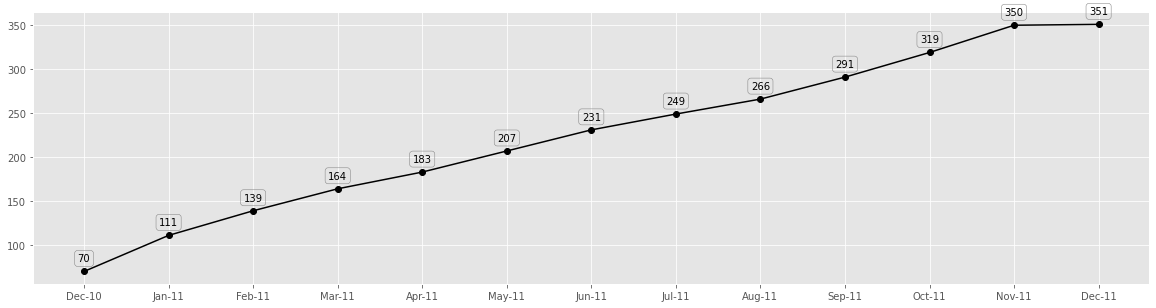

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(20,5))
plt.plot(customer_by_month.Month_1,customer_by_month.cum_customer,'bo-',color='black')

# zip joins x and y coordinates in pairs
for d,c in zip(customer_by_month['Month_1'],customer_by_month['cum_customer']):

    label = "{:.0f}".format(c)

    plt.annotate(label, 
                 (d,c), 
                 textcoords="offset points"
                 , bbox=dict(boxstyle="round", fc="none", ec="gray")
                 #,arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=10,rad=90")
                 ,xytext=(0,10),
                 ha='center') 
plt.show()

del customer_by_month


Customer acquisition VS Sales contribution

In [16]:
customer_sales = df_.groupby(by = ['CustomerID','Year','Quarter'])['Sales'].sum().reset_index()
customer_sales = customer_sales.merge(customer_by_month1[['CustomerID','Quarter_acquisition','Year_acquisition']]
                                      ,on ='CustomerID',how='inner')
customer_sales_acquisition = customer_sales.groupby(by=['Year','Quarter','Year_acquisition','Quarter_acquisition'])['Sales'].sum().reset_index()
customer_sales_acquisition['Sales_Year_quarter'] =customer_sales_acquisition[['Year','Quarter']].apply(lambda row:str(row.Year)+'-'+row.Quarter,axis=1)
customer_sales_acquisition['Acquisition_Year_quarter'] =customer_sales_acquisition[['Year_acquisition','Quarter_acquisition']].apply(lambda row:str(row.Year_acquisition)+'-'+row.Quarter_acquisition,axis=1)
customer_sales_acquisition.drop(columns =['Year','Quarter','Year_acquisition','Quarter_acquisition'],inplace=True)
df = customer_sales_acquisition.pivot(index='Sales_Year_quarter',columns =['Acquisition_Year_quarter']).fillna(0).reset_index()


fig = go.Figure(data=[
    go.Bar(name='First Order 2010-Q4', x=df.Sales_Year_quarter, y=df.iloc[:,1],marker_color='lightslategrey'),
    go.Bar(name='First Order 2011-Q1', x=df.Sales_Year_quarter, y=df.iloc[:,2],marker_color='lightblue'),
    go.Bar(name='First Order 2011-Q2', x=df.Sales_Year_quarter, y=df.iloc[:,3],marker_color='seagreen'),
    go.Bar(name='First Order 2011-Q3', x=df.Sales_Year_quarter, y=df.iloc[:,4],marker_color='orange')
])
fig.update_layout(barmode='stack',template='ggplot2')
fig.show()

del [customer_sales_acquisition, df,customer_sales]

Frequent purchasing:
Most of customers made their next purchase after one or two months of first purchase.
There were 28 customers who made their first purchase in Dec 2010 also made their next purchase after 12 months.33 customers made their second purchase after 7 months of their first purchase in Mar 2011.

Hourly sales

In [17]:
sales_by_hour = df_.groupby(by='Hour')['Sales'].mean().reset_index()
sales_by_weekday = df_.groupby(by='weekday')['Sales'].mean().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Avg Hourly Sales", "Avg Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()

del [sales_by_hour,sales_by_weekday]

In [18]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols('Sales ~ C(Hour)',data=df_).fit()
#ols.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)
del [table,model]

                sum_sq       df         F        PR(>F)
C(Hour)   1.433664e+06     13.0  27.71196  9.528086e-69
Residual  2.119085e+08  53249.0       NaN           NaN


In [19]:
LRFM = df_.groupby('CustomerID').agg(Frequency=pd.NamedAgg(column="InvoiceNo", aggfunc="nunique")
                                        ,Monetary=pd.NamedAgg(column="Sales", aggfunc="sum")).reset_index()

length = df_.groupby('CustomerID')['Date'].max() - df_.groupby('CustomerID')['Date'].min()
length =  (length/np.timedelta64(1, 'D')).reset_index()
length.columns = ['CustomerID','Length_of_stay']
LRFM = LRFM.merge(length,on='CustomerID',how='inner')
del length

LRFM.head()

CustomerID  Frequency  Monetary  Length_of_stay
0     12347.0          7    358.67           365.0
1     12348.0          2     54.48            40.0
2     12349.0          1    105.18             0.0
3     12350.0          1     19.80             0.0
4     12352.0          6    178.05           260.0

#### 3 Dimensional View

In [20]:
fig = go.Figure(data=[go.Scatter3d(x=LRFM.Monetary,y=LRFM.Length_of_stay,z=LRFM.Frequency,mode='markers'
                                   ,marker=dict(size=4,color='coral',colorscale='Viridis',opacity=0.8))])
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Frequency')),width=800,height=500)
fig.show()

K Means Clustering

In [29]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE

In [30]:
X=LRFM.drop(columns = 'CustomerID')
error = []
silhouette = []
np.random.seed(12)
rng = range(2,20)
for i in rng:
    km = KMeans(n_clusters=i, init='random',n_init=20, max_iter=200,tol=.0001, random_state=12)
    km.fit(X)
    error.append(km.inertia_)
    lbls = km.fit_predict(X)
    silhouette.append(silhouette_score(X, lbls))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Number of Cluster vs Error", "Number of Cluster vs Silhouette"))
fig.add_trace(go.Scatter(x=list(rng), y=error),row=1, col=1)
fig.add_trace(go.Scatter(x=list(rng), y=silhouette),row=1, col=2)
fig.update_layout(height=500, width=800,template='ggplot2')
fig.update_xaxes(title_text="Number of Clusters", row=1, col=1)
fig.update_xaxes(title_text="Number of Clusters", row=1, col=2)
fig.update_yaxes(title_text="Errors", row=1, col=1)
fig.update_yaxes(title_text="Silhouette Distance", row=1, col=2)
fig.show()

del [error,silhouette,rng,km,lbls,X]

Creating Cluster

In [36]:
X=LRFM.drop(columns = 'CustomerID')
cluster_lbls = KMeans(n_clusters=10, random_state=12).fit_predict(X)
X['cluster'] = cluster_lbls
X['sample_silhouette_values'] = silhouette_samples(X, cluster_lbls)
X['txt']=X.cluster.apply(lambda x:'Cluster '+str(x))

Sample vs Silhouette

In [35]:
fig = go.Figure(data=go.Scatter(x=X.Monetary,y=X.sample_silhouette_values
                                , mode='markers',marker_color=X.cluster,text = X.txt))

fig.update_layout(xaxis_title="Sales",yaxis_title="Silhouette"
                  ,title='Sample Size vs Silhoutte Values')

fig.show()


In [38]:
df = X.groupby('cluster').agg({'cluster':'size', 'Monetary':'mean','Frequency':'mean','Length_of_stay':'mean'}) \
       .rename(columns={'cluster':'Size','Monetary':'Avg Sales','Frequency':'Avg Recency','Length_of_stay':'Avg Lenght of Stay'}) \
       .reset_index().sort_values(by = 'Avg Sales')

cluster_map ={'Cluster 4':'lightskyblue','Cluster 0':'lightskyblue','Cluster 8':'lightskyblue'
              ,'Cluster 6':'lightskyblue','Cluster 2':'lightskyblue',
             'Cluster 3':'orange','Cluster 7':'orange','Cluster 9':'orange'
              ,'Cluster 1':'olive','Cluster 5':'olive'}

txt =['Size = {0:.0f}'.format(i) for i in df.Size]
df['cluster']=df.cluster.apply(lambda x:'Cluster '+str(x))
df['Group']=df.cluster.map(cluster_map)

fig = make_subplots(rows=1, cols=3,subplot_titles=("Avg Sales", "Avg Recency",'Avg Lenght of Stay'))

fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Sales'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Recency'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=2)
fig.add_trace(go.Bar(y=df.cluster, x=df['Avg Lenght of Stay'],hovertext=txt
                        ,text=txt,textposition='auto',marker_color=df.Group,orientation='h'),row=1, col=3)

fig.update_traces(marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.8)
fig.update_layout(title_text='Cluster Size',width = 800,height=600,template='ggplot2'
                  ,font=dict(family="Courier New, monospace",size=10,color="RebeccaPurple"))

fig.show()

Cluster 3 Dimensional View

In [39]:
fig = go.Figure(data=[go.Scatter3d(x=X.Monetary,y=X.Length_of_stay,z=X.Frequency,mode='markers'
                                   ,marker=dict(size=4,color=X.cluster
                                                ,colorscale='Viridis',opacity=0.8))])

# tight layout
fig.update_layout(margin=dict(l=1, r=2, b=1, t=1)
                  ,scene=dict(xaxis=dict(title='Sales')
                              ,yaxis=dict(title='Lenght of Stay')
                              ,zaxis=dict(title='Recency')),width=700,height=500)
fig.show()